# Dependencies

In [1]:
# 1) Import SQLalchemy to create the conection to the Database
from sqlalchemy import create_engine, func, inspect
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import session

In [2]:
# 2) Data Managment
import pandas as pd
import numpy as np

# 2.1) Data Preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [3]:
# Display
pd.set_option('display.float_format',lambda x:"%.4f"%x)

In [4]:
# 3) Data Visualization
import seaborn as sns

In [5]:
# 4) ML Model. Logistic Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Load Data

In [6]:
from access.config import db_password
db_host = 'data-analytics-final-project-t2.ceptpmc0vrha.us-east-1.rds.amazonaws.com'
db_name = 'Medical_Data'

db_string = f"postgresql://postgres:{db_password}@{db_host}:5432/{db_name}"
engine = create_engine(db_string)

In [7]:
inspector = inspect(engine)
inspector.get_table_names()

['identification',
 'comorbilities',
 'autoimmune_disease',
 'cancer',
 'smoking',
 'death',
 'vital_signs',
 'evolution',
 'immunosuppression',
 'patients_final',
 'patients_clusters']

In [8]:
patients = pd.read_sql_table('patients_final',db_string,index_col="identification")

In [9]:
covid_patients = patients[patients['covid_test_negative']==False]

# Variable Categorization

We'll discriminate the continous variables (varc) from the discrete ones (vard)

In [10]:
pd.set_option('display.max_columns', None)

In [11]:
covid_patients.sample(n=3)

,healthcare_center,covid_test_negative,covid_test_positive,pcr_antigen,inclusion_positive_covid_tests,exclusion_nofile,birth_date,age,sex,pregnancy,admission_date,symptons_onset,comorbilities,obesity,diabetes_mellitus,arterial_hypertension,autoimmune_disease,immunosuppression,cancer,smoking,alcoholism,copd,interstitial_lung_disease,tuberculosis,asthma,cardiovascular_disease,renal_disease,hepatic_disease,neurological_disease,systemic_lupus_erythematosus,rheumatoid_arthritis,scleroderma,psoriasis,inflammatory_bowel_disease,vasculitis,hiv,organ_transplantation,use_of_immunosuppressants,primary_immunodeficiency,splenectomy,hematological_cancer,active_cancer,others_cancer,active_smoking,years_smoking,cigarrettes_per_day,vaccination,temperature_c,respiratory_rate,heart_rate,oximeter_saturation,systolic_blood_pressure,diastolic_blood_pressure,height_cm,weight_kg,glasgow_coma_scale,dopamine,dosis_of_dopamine_or_norepinephrine,mean_arterial_pressure,use_of_oxygen_before_arrival,administration_of_oxygen_in_any_modality_at_any_time_during_the,maximum_respiratory_support_during_any_time_of_the_hospitalizat,imv_respiratory_support,pronation_respiratory_support,ecmo_respiratory_support,date_of_intubation,date_of_extubation,peritoneal_dialysis,hemodialysis,outcome,leaving_date,stay_lenght,death_with_imv,acute_myocardial_infarction,respiratory_failure_due_to_covid,tia,sudden_death_not_specified,pulmonary_thromboembolism,sepsis,nosocomial_infection,other,sudden_death_massive_tia_heart_attack_pulmonary_embolism,rejected_intubation_or_terminal_disease,fan_unavailability,other_cause,died_in_the_first_24_hours_of_hospitalization,latitude,longitude
identification,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3353,HRAEI,False,True,PCR,True,False,1977-08-22,43.98447607,Male,False,2020-10-05,7,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0,False,36.9,15,58,85,195,120,160,105,13 - 14,False,No dosis,145,1,False,Nasal cannula,False,False,False,1970-01-01,1970-01-01,False,False,Discharge home for improvement,2020-10-06,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,19.31893,-98.85468
5196,HRAEPY,False,True,Antigen,True,False,1993-01-06,28.8356366,Male,False,2021-03-23,11,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0,False,36.6,30,78,85,120,70,176,80,15,False,No dosis,86.66666667,1,True,Nasal cannula,False,False,False,1970-01-01,1970-01-01,False,False,Discharge home for improvement,2021-03-28,5,False,False,False,False,False,False,False,False,False,False,False,False,False,False,21.02033,-89.5819
5023,HRAEI,False,True,PCR,True,False,1957-09-02,64.13547164,Female,False,2021-08-25,4,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0,False,36.5,20,68,99,100,60,150,120,13 - 14,False,No dosis,73.33333333,1,False,Invasive Mechanical Ventilation,True,False,False,2021-08-29,2021-09-13,False,False,Discharge home for improvement,2021-09-24,30,False,False,False,False,False,False,False,False,False,False,False,False,False,False,19.31893,-98.85468


In [12]:
vard = 'healthcare_center	covid_test_negative	covid_test_positive	pcr_antigen	inclusion_positive_covid_tests	exclusion_nofile	sex	pregnancy	comorbilities	obesity	diabetes_mellitus	arterial_hypertension	autoimmune_disease	immunosuppression	cancer	smoking	alcoholism	copd	interstitial_lung_disease	tuberculosis	asthma	cardiovascular_disease	renal_disease	hepatic_disease	neurological_disease	systemic_lupus_erythematosus	rheumatoid_arthritis	scleroderma	psoriasis	inflammatory_bowel_disease	vasculitis	hiv	organ_transplantation	use_of_immunosuppressants	primary_immunodeficiency	splenectomy	hematological_cancer	active_cancer	others_cancer	active_smoking	vaccination	glasgow_coma_scale	dopamine	dosis_of_dopamine_or_norepinephrine	use_of_oxygen_before_arrival	administration_of_oxygen_in_any_modality_at_any_time_during_the	maximum_respiratory_support_during_any_time_of_the_hospitalizat	imv_respiratory_support	pronation_respiratory_support	ecmo_respiratory_support	peritoneal_dialysis	hemodialysis	outcome	death_with_imv	acute_myocardial_infarction	respiratory_failure_due_to_covid	tia	sudden_death_not_specified	pulmonary_thromboembolism	sepsis	nosocomial_infection	other	sudden_death_massive_tia_heart_attack_pulmonary_embolism	rejected_intubation_or_terminal_disease	fan_unavailability	other_cause	died_in_the_first_24_hours_of_hospitalization'
varc = ['age','symptons_onset','years_smoking','cigarrettes_per_day','temperature_c','respiratory_rate','heart_rate','oximeter_saturation','systolic_blood_pressure','diastolic_blood_pressure','height_cm','weight_kg','mean_arterial_pressure','stay_lenght']
dates = ['birth_date','admission_date','date_of_intubation','date_of_extubation','leaving_date']
lat_lon = 'latitude	longitude'

# split vard and lat_lon
vard = vard.split('	')
lat_lon = lat_lon.split('	')

# Exploratory Analisis

## Discrete

For this columns, we'll analyze the frequencies for the variables of each column.

In [13]:
def freq(df,var):
    
    # the var we want to analyze is a list
    if type(var)!=list:
        var = [var]
    
    for v in var:
        # Make a pd.dataframe with the values counts
        aux = df[v].value_counts().to_frame()
        
        # rename the Count column to 'AF':
        # Absolute Frequency
        aux.columns = ['AF']
        
        # Get the Relative Frequency (FR)
        aux['RF'] = aux['AF']/aux['AF'].sum()
        
        # Print the results
        print(f"Frequencies Table for the Column \033[1m** {v} **\033[0m",end="\n")
        print(aux,end="\n"*2)

In [14]:
freq(covid_patients,vard)

Frequencies Table for the Column ** healthcare_center **
              AF     RF
HRAEI       3858 0.7374
INER         871 0.1665
HJM          156 0.0298
GEA          140 0.0268
HRAEPY        45 0.0086
HIM           45 0.0086
HGM           43 0.0082
HRAEO         43 0.0082
Nutrici√≥n    14 0.0027
HRAECV        12 0.0023
HRAEB          3 0.0006
INCICH         1 0.0002
HRAECS         1 0.0002

Frequencies Table for the Column ** covid_test_negative **
         AF     RF
False  5232 1.0000

Frequencies Table for the Column ** covid_test_positive **
        AF     RF
True  5232 1.0000

Frequencies Table for the Column ** pcr_antigen **
           AF     RF
PCR      5119 0.9784
Antigen   113 0.0216

Frequencies Table for the Column ** inclusion_positive_covid_tests **
         AF     RF
True   5002 0.9560
False   230 0.0440

Frequencies Table for the Column ** exclusion_nofile **
         AF     RF
False  5232 1.0000

Frequencies Table for the Column ** sex **
          AF     RF
Male    326

### Normalize

Locate those values where the **Relative Frequency** is low.

For the analysis, lets consider that less than 10% a low frequency 

In [15]:
def normalize(df,var,treshold=0.01):
    # Get the RF, using .value_counts(True)
    aux = df[var].value_counts(True).to_frame()

    # Locate those values which RF is less than the treshold, as OTHERS
    aux['norm'] = np.where(aux[var]<treshold,'OTHERS',aux.index)
    
    # Save the mode
    mode = aux.head(1)['norm'].values[0]
    
    # If the sum of OTHERS variables is less than the umbral
    if aux[aux['norm']=='OTHERS'][var].sum()<treshold:
        # Replace those values with the mode
        aux['norm'].replace({'OTHERS':mode},inplace=True)
    
    aux.drop(var,axis=1,inplace=True)
    df = df.replace({var:aux.to_dict()['norm']})
    return df

In [16]:
# Apply the normalize function to all the discrete columns 
for var in vard:
    covid_patients = normalize(covid_patients,var)

In [17]:
freq(covid_patients,vard)

Frequencies Table for the Column ** healthcare_center **
          AF     RF
HRAEI   3858 0.7374
INER     871 0.1665
OTHERS   207 0.0396
HJM      156 0.0298
GEA      140 0.0268

Frequencies Table for the Column ** covid_test_negative **
         AF     RF
False  5232 1.0000

Frequencies Table for the Column ** covid_test_positive **
        AF     RF
True  5232 1.0000

Frequencies Table for the Column ** pcr_antigen **
           AF     RF
PCR      5119 0.9784
Antigen   113 0.0216

Frequencies Table for the Column ** inclusion_positive_covid_tests **
         AF     RF
True   5002 0.9560
False   230 0.0440

Frequencies Table for the Column ** exclusion_nofile **
         AF     RF
False  5232 1.0000

Frequencies Table for the Column ** sex **
          AF     RF
Male    3264 0.6239
Female  1968 0.3761

Frequencies Table for the Column ** pregnancy **
         AF     RF
False  5232 1.0000

Frequencies Table for the Column ** comorbilities **
         AF     RF
False  3270 0.6250
True   

### Drop Univariate Columns

We notice that many of the columns only have one value now.

In [18]:
# Locate those unary columns with a list comprehension
unary_list = [v for v,n in zip(vard,[covid_patients[v].unique().shape[0] for v in vard]) if n == 1]

print(unary_list)
print(f"We'll be deleting: {len(unary_list)} columns")

['covid_test_negative', 'covid_test_positive', 'exclusion_nofile', 'pregnancy', 'autoimmune_disease', 'immunosuppression', 'cancer', 'copd', 'interstitial_lung_disease', 'tuberculosis', 'asthma', 'renal_disease', 'hepatic_disease', 'neurological_disease', 'systemic_lupus_erythematosus', 'rheumatoid_arthritis', 'scleroderma', 'psoriasis', 'inflammatory_bowel_disease', 'vasculitis', 'hiv', 'organ_transplantation', 'use_of_immunosuppressants', 'primary_immunodeficiency', 'splenectomy', 'hematological_cancer', 'active_cancer', 'others_cancer', 'ecmo_respiratory_support', 'peritoneal_dialysis', 'acute_myocardial_infarction', 'tia', 'sudden_death_not_specified', 'pulmonary_thromboembolism', 'other', 'sudden_death_massive_tia_heart_attack_pulmonary_embolism', 'rejected_intubation_or_terminal_disease', 'fan_unavailability', 'other_cause']
We'll be deleting: 39 columns


In [19]:
# Notice that zip is getting together 'healthcare_center':5,'covid_test_negative':1, 'pcr_antigen':2 and 'inclusion_positive_covid_tests': 2 so on
print(vard,[covid_patients[v].unique().shape[0] for v in vard])

['healthcare_center', 'covid_test_negative', 'covid_test_positive', 'pcr_antigen', 'inclusion_positive_covid_tests', 'exclusion_nofile', 'sex', 'pregnancy', 'comorbilities', 'obesity', 'diabetes_mellitus', 'arterial_hypertension', 'autoimmune_disease', 'immunosuppression', 'cancer', 'smoking', 'alcoholism', 'copd', 'interstitial_lung_disease', 'tuberculosis', 'asthma', 'cardiovascular_disease', 'renal_disease', 'hepatic_disease', 'neurological_disease', 'systemic_lupus_erythematosus', 'rheumatoid_arthritis', 'scleroderma', 'psoriasis', 'inflammatory_bowel_disease', 'vasculitis', 'hiv', 'organ_transplantation', 'use_of_immunosuppressants', 'primary_immunodeficiency', 'splenectomy', 'hematological_cancer', 'active_cancer', 'others_cancer', 'active_smoking', 'vaccination', 'glasgow_coma_scale', 'dopamine', 'dosis_of_dopamine_or_norepinephrine', 'use_of_oxygen_before_arrival', 'administration_of_oxygen_in_any_modality_at_any_time_during_the', 'maximum_respiratory_support_during_any_time_of

In [20]:
for v in unary_list:
    vard.remove(v)

covid_patients.drop(unary_list,axis=1,inplace=True)

In [21]:
freq(covid_patients,vard)

Frequencies Table for the Column ** healthcare_center **
          AF     RF
HRAEI   3858 0.7374
INER     871 0.1665
OTHERS   207 0.0396
HJM      156 0.0298
GEA      140 0.0268

Frequencies Table for the Column ** pcr_antigen **
           AF     RF
PCR      5119 0.9784
Antigen   113 0.0216

Frequencies Table for the Column ** inclusion_positive_covid_tests **
         AF     RF
True   5002 0.9560
False   230 0.0440

Frequencies Table for the Column ** sex **
          AF     RF
Male    3264 0.6239
Female  1968 0.3761

Frequencies Table for the Column ** comorbilities **
         AF     RF
False  3270 0.6250
True   1962 0.3750

Frequencies Table for the Column ** obesity **
         AF     RF
False  4214 0.8054
True   1018 0.1946

Frequencies Table for the Column ** diabetes_mellitus **
         AF     RF
False  4413 0.8435
True    819 0.1565

Frequencies Table for the Column ** arterial_hypertension **
         AF     RF
False  4484 0.8570
True    748 0.1430

Frequencies Table for the

But we won't need all the columns. For instance:
- inclusion_positive_covid_tests
- died_in_the_first_24_hours_of_hospitalization 

In [22]:
delete = ['inclusion_positive_covid_tests','died_in_the_first_24_hours_of_hospitalization']
covid_patients.drop(delete,axis=1,inplace=True)
for v in delete:
    vard.remove(v)

### Boolean Columns

Transform the boolean columns to numeric

In [23]:
binary = [column for column in covid_patients[vard].columns.to_list()
             if len(covid_patients[column].value_counts())==2]
for v in ['pcr_antigen','sex','use_of_oxygen_before_arrival','outcome']:
    binary.remove(v)
for v in binary:
    covid_patients[v] = covid_patients[v].astype(int)

In [24]:
covid_patients.head(2)

,healthcare_center,pcr_antigen,birth_date,age,sex,admission_date,symptons_onset,comorbilities,obesity,diabetes_mellitus,arterial_hypertension,smoking,alcoholism,cardiovascular_disease,active_smoking,years_smoking,cigarrettes_per_day,vaccination,temperature_c,respiratory_rate,heart_rate,oximeter_saturation,systolic_blood_pressure,diastolic_blood_pressure,height_cm,weight_kg,glasgow_coma_scale,dopamine,dosis_of_dopamine_or_norepinephrine,mean_arterial_pressure,use_of_oxygen_before_arrival,administration_of_oxygen_in_any_modality_at_any_time_during_the,maximum_respiratory_support_during_any_time_of_the_hospitalizat,imv_respiratory_support,pronation_respiratory_support,date_of_intubation,date_of_extubation,hemodialysis,outcome,leaving_date,stay_lenght,death_with_imv,respiratory_failure_due_to_covid,sepsis,nosocomial_infection,latitude,longitude
identification,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,INER,PCR,1969-11-14,51.76834569,Male,2021-03-20,6,1,0,1,0,0,0,0,0,0,0,1,36.5,50,113,76,127,81,163,73,15,0,No dosis,96.33333333,0,0,Invasive Mechanical Ventilation,0,1,2021-03-20,2021-04-12,0,Death,2021-04-12,23,1,1,0,1,19.29412,-99.15617
2,INER,PCR,1981-09-03,39.99260765,Male,2021-03-10,8,1,0,1,0,1,0,0,0,0,0,0,37.4,36,100,87,130,83,168,75,15,0,No dosis,98.66666667,1,0,Invasive Mechanical Ventilation,0,1,2021-03-10,2021-03-24,1,Discharge home for improvement,2021-04-02,23,0,0,0,0,19.29412,-99.15617


## Continous Columns

In [25]:
covid_patients[varc] = covid_patients[varc].astype(float)
covid_patients[varc].head(2)

,age,symptons_onset,years_smoking,cigarrettes_per_day,temperature_c,respiratory_rate,heart_rate,oximeter_saturation,systolic_blood_pressure,diastolic_blood_pressure,height_cm,weight_kg,mean_arterial_pressure,stay_lenght
identification,,,,,,,,,,,,,,
1,51.7683,6.0000,0.0000,0.0000,36.5000,50.0000,113.0000,76.0000,127.0000,81.0000,163.0000,73.0000,96.3333,23.0000
2,39.9926,8.0000,0.0000,0.0000,37.4000,36.0000,100.0000,87.0000,130.0000,83.0000,168.0000,75.0000,98.6667,23.0000


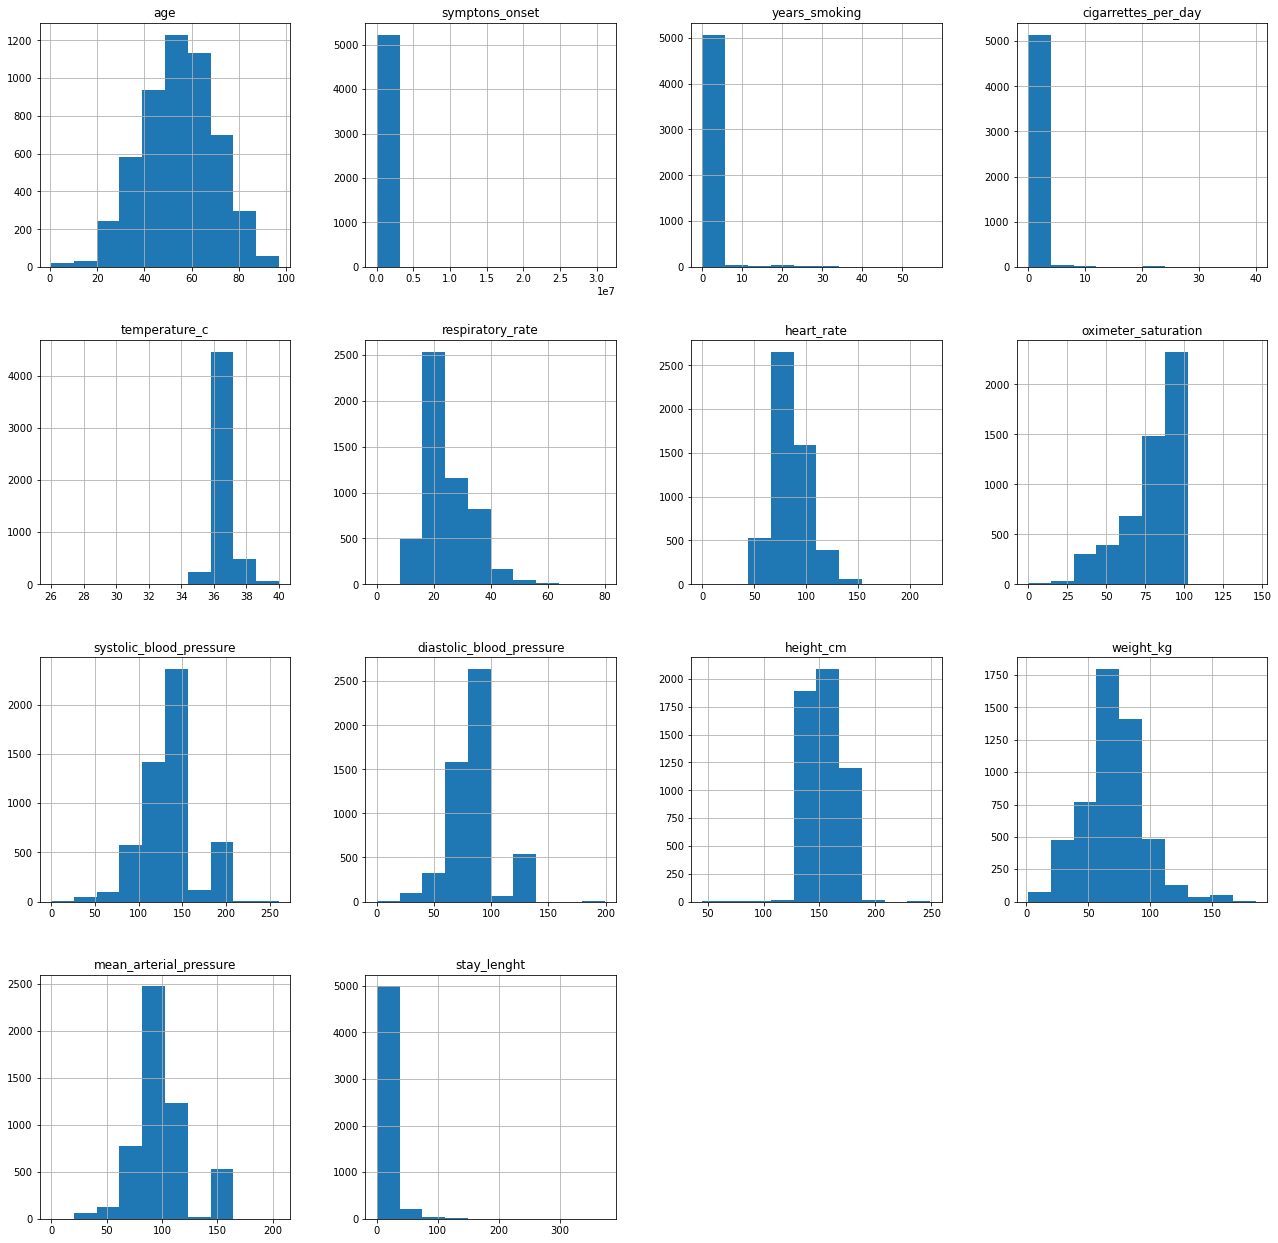

In [26]:
z = covid_patients[varc].astype(float).hist(figsize=(22,22))

### Extrem Values

Get the limits using percentiles

In [27]:
limits = covid_patients[varc].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values
limits

array([['age', 19.63912104, 88.00607815129997],
       ['symptons_onset', 2.0, 20.0],
       ['years_smoking', 0.0, 25.0],
       ['cigarrettes_per_day', 0.0, 5.6899999999996],
       ['temperature_c', 35.1, 38.6],
       ['respiratory_rate', 13.0, 50.0],
       ['heart_rate', 58.0, 133.0],
       ['oximeter_saturation', 30.0, 99.0],
       ['systolic_blood_pressure', 55.31, 195.0],
       ['diastolic_blood_pressure', 30.0, 120.0],
       ['height_cm', 140.0, 183.0],
       ['weight_kg', 18.1, 151.3799999999992],
       ['mean_arterial_pressure', 39.66666667, 145.0],
       ['stay_lenght', 0.0, 71.0]], dtype=object)

In [28]:
covid_patients_ext = covid_patients.copy()

for v,li,ls in limits:
    # If there's a value in the v column, then mark it with 1
    covid_patients_ext[f'ext_{v}'] = ((covid_patients_ext[v]<li)|(covid_patients_ext[v]>ls)).astype(int)
covid_patients_ext['ext'] = covid_patients_ext.filter(like='ext_').max(axis=1)

# Using the frequency function, we'll know how many extreme values we have in the dataset
freq(covid_patients_ext,'ext')

Frequencies Table for the Column ** ext **
     AF     RF
0  4596 0.8784
1   636 0.1216



In [29]:
covid_patients[varc].describe(percentiles=[0.01,0.05,0.95,0.99]).T

,count,mean,std,min,1%,5%,50%,95%,99%,max
age,5232.0000,54.6170,15.4945,0.4546,19.6391,28.5454,55.0662,79.6100,88.0061,96.9300
symptons_onset,5232.0000,15941.1745,621472.3510,-7.0000,2.0000,4.0000,8.0000,15.0000,20.0000,31082021.0000
years_smoking,5232.0000,0.6960,4.3599,0.0000,0.0000,0.0000,0.0000,0.0000,25.0000,57.0000
cigarrettes_per_day,5232.0000,0.2091,1.7790,0.0000,0.0000,0.0000,0.0000,0.0000,5.6900,40.0000
temperature_c,5232.0000,36.5793,0.6095,26.0000,35.1000,35.9000,36.5000,37.6000,38.6000,40.0000
respiratory_rate,5232.0000,23.9276,8.2465,0.0000,13.0000,15.0000,22.0000,38.0000,50.0000,80.0000
heart_rate,5232.0000,84.9742,17.4603,0.0000,58.0000,59.0000,85.0000,116.0000,133.0000,220.0000
oximeter_saturation,5232.0000,79.8407,18.4044,0.0000,30.0000,40.0000,85.0000,99.0000,99.0000,146.0000
systolic_blood_pressure,5232.0000,132.2490,30.3211,0.0000,55.3100,90.0000,130.0000,195.0000,195.0000,260.0000
diastolic_blood_pressure,5232.0000,81.3563,18.9503,0.0000,30.0000,52.0000,80.0000,120.0000,120.0000,199.0000


In [30]:
covid_patients=covid_patients.loc[covid_patients['symptons_onset']<=31]
covid_patients=covid_patients.loc[covid_patients['symptons_onset']>=0]
# covid_patients=covid_patients.loc[covid_patients['height_cm']<=220]
covid_patients=covid_patients.loc[covid_patients['stay_lenght']<=90]

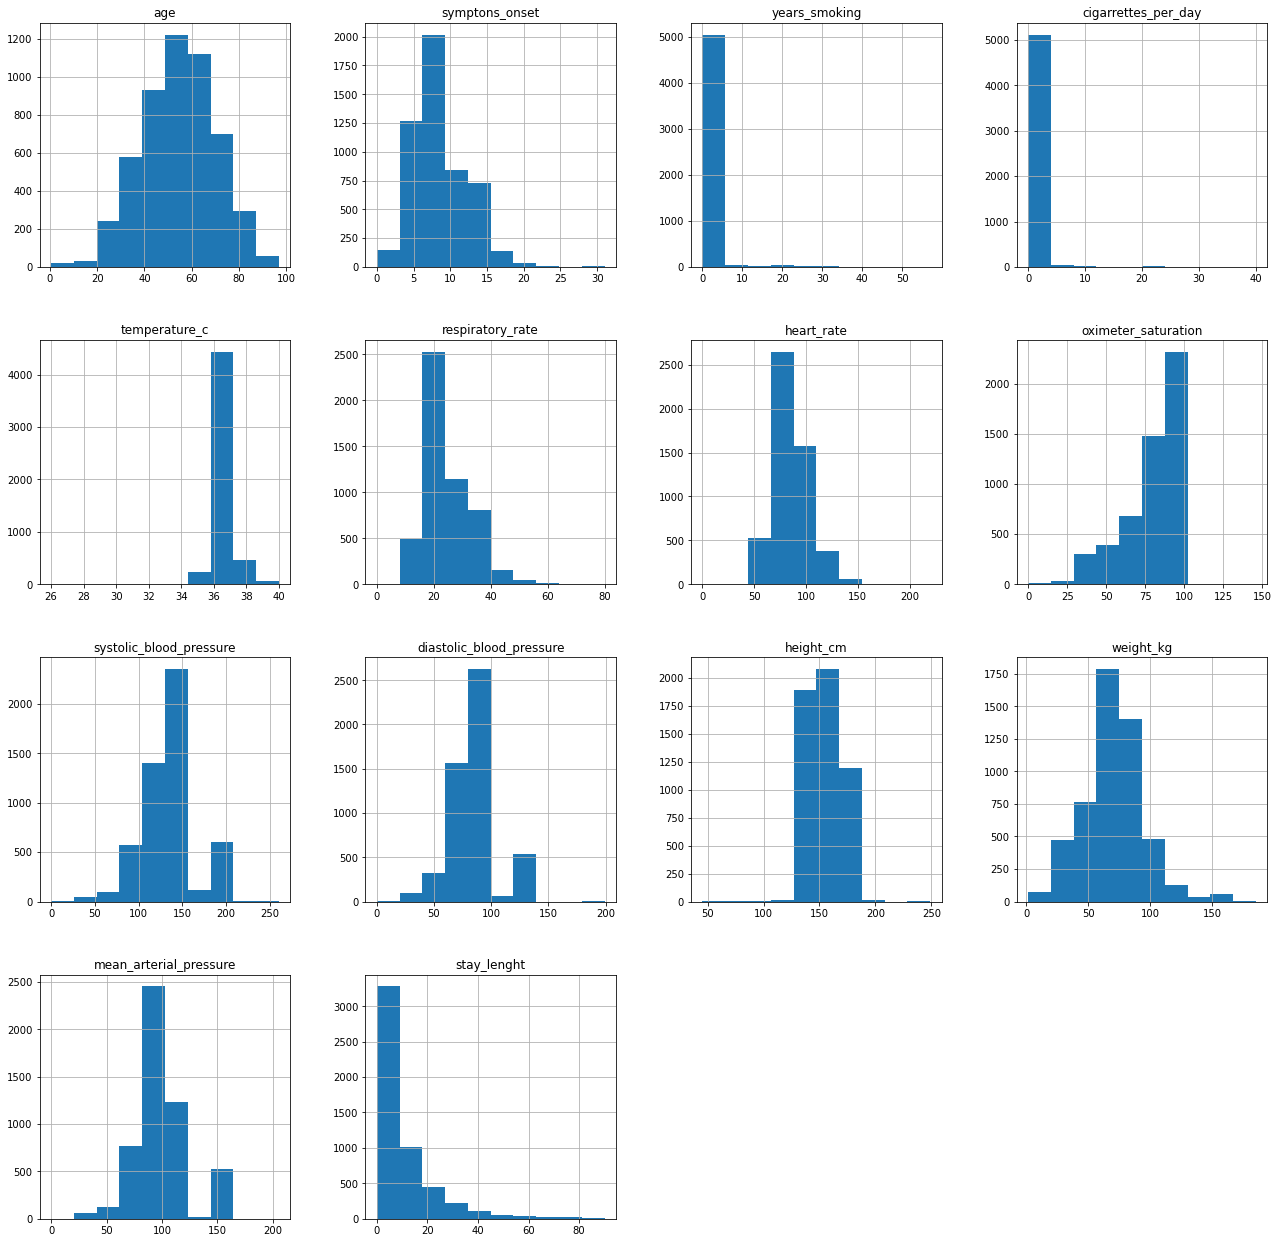

In [31]:
z = covid_patients[varc].astype(float).hist(figsize=(22,22))

### Correlated Columns

In [32]:
# sns.pairplot(covid_patients[varc])

<AxesSubplot:xlabel='mean_arterial_pressure', ylabel='systolic_blood_pressure'>

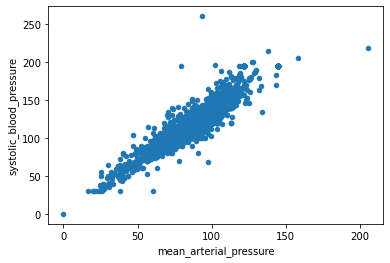

In [33]:
# Here, we can notice that some variables aren't independent:
covid_patients.plot(kind='scatter',x='mean_arterial_pressure',y='systolic_blood_pressure')

<AxesSubplot:xlabel='mean_arterial_pressure', ylabel='diastolic_blood_pressure'>

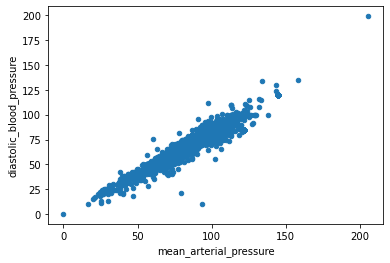

In [34]:
covid_patients.plot(kind='scatter',x='mean_arterial_pressure',y='diastolic_blood_pressure')

In [35]:
covid_patients = covid_patients.drop('mean_arterial_pressure',axis=1)

varc.remove('mean_arterial_pressure')

## Recall

In [36]:
covid_patients.shape

(5203, 46)

In [37]:
print(covid_patients.columns.to_list())

['healthcare_center', 'pcr_antigen', 'birth_date', 'age', 'sex', 'admission_date', 'symptons_onset', 'comorbilities', 'obesity', 'diabetes_mellitus', 'arterial_hypertension', 'smoking', 'alcoholism', 'cardiovascular_disease', 'active_smoking', 'years_smoking', 'cigarrettes_per_day', 'vaccination', 'temperature_c', 'respiratory_rate', 'heart_rate', 'oximeter_saturation', 'systolic_blood_pressure', 'diastolic_blood_pressure', 'height_cm', 'weight_kg', 'glasgow_coma_scale', 'dopamine', 'dosis_of_dopamine_or_norepinephrine', 'use_of_oxygen_before_arrival', 'administration_of_oxygen_in_any_modality_at_any_time_during_the', 'maximum_respiratory_support_during_any_time_of_the_hospitalizat', 'imv_respiratory_support', 'pronation_respiratory_support', 'date_of_intubation', 'date_of_extubation', 'hemodialysis', 'outcome', 'leaving_date', 'stay_lenght', 'death_with_imv', 'respiratory_failure_due_to_covid', 'sepsis', 'nosocomial_infection', 'latitude', 'longitude']


Other useless columns are:

- 'birth_date'

In [38]:
delete = ['birth_date']+lat_lon
covid_patients.drop(delete,axis=1,inplace=True)

# Data Preprocessing

In [39]:
covid_patients

,healthcare_center,pcr_antigen,age,sex,admission_date,symptons_onset,comorbilities,obesity,diabetes_mellitus,arterial_hypertension,smoking,alcoholism,cardiovascular_disease,active_smoking,years_smoking,cigarrettes_per_day,vaccination,temperature_c,respiratory_rate,heart_rate,oximeter_saturation,systolic_blood_pressure,diastolic_blood_pressure,height_cm,weight_kg,glasgow_coma_scale,dopamine,dosis_of_dopamine_or_norepinephrine,use_of_oxygen_before_arrival,administration_of_oxygen_in_any_modality_at_any_time_during_the,maximum_respiratory_support_during_any_time_of_the_hospitalizat,imv_respiratory_support,pronation_respiratory_support,date_of_intubation,date_of_extubation,hemodialysis,outcome,leaving_date,stay_lenght,death_with_imv,respiratory_failure_due_to_covid,sepsis,nosocomial_infection
identification,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,INER,PCR,51.7683,Male,2021-03-20,6.0000,1,0,1,0,0,0,0,0,0.0000,0.0000,1,36.5000,50.0000,113.0000,76.0000,127.0000,81.0000,163.0000,73.0000,15,0,No dosis,0,0,Invasive Mechanical Ventilation,0,1,2021-03-20,2021-04-12,0,Death,2021-04-12,23.0000,1,1,0,1
2,INER,PCR,39.9926,Male,2021-03-10,8.0000,1,0,1,0,1,0,0,0,0.0000,0.0000,0,37.4000,36.0000,100.0000,87.0000,130.0000,83.0000,168.0000,75.0000,15,0,No dosis,1,0,Invasive Mechanical Ventilation,0,1,2021-03-10,2021-03-24,1,Discharge home for improvement,2021-04-02,23.0000,0,0,0,0
3,INER,PCR,45.4520,Male,2020-05-12,8.0000,0,0,0,0,0,0,0,0,0.0000,0.0000,0,38.5000,38.0000,113.0000,95.0000,110.0000,67.0000,170.0000,80.0000,15,1,DA >5 mcg/Kg/min or NA <=0.1 mcg/Kg/min,0,0,Invasive Mechanical Ventilation,0,1,2020-05-13,2020-06-20,0,Discharge home for improvement,2020-06-28,47.0000,0,0,0,0
4,INER,PCR,56.9813,Male,2021-03-11,8.0000,1,0,0,0,1,0,0,0,0.0000,0.0000,0,36.0000,36.0000,130.0000,54.0000,140.0000,80.0000,155.0000,62.0000,15,0,No dosis,1,0,Invasive Mechanical Ventilation,0,1,2021-03-11,2021-03-25,0,Discharge home for improvement,2021-04-02,22.0000,0,0,0,0
5,INER,PCR,40.9454,Female,2021-01-23,8.0000,1,0,1,0,1,0,0,0,0.0000,0.0000,0,37.0000,36.0000,99.0000,70.4000,147.0000,81.0000,179.0000,73.0000,15,0,No dosis,1,0,Invasive Mechanical Ventilation,0,1,2021-01-23,2021-02-25,0,Discharge home for improvement,2021-03-16,52.0000,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5373,OTHERS,Antigen,70.2081,Female,2021-08-21,20.0000,1,0,1,1,0,0,0,0,0.0000,0.0000,1,37.2000,40.0000,105.0000,90.0000,140.0000,95.0000,150.0000,70.0000,<6,0,No dosis,1,1,Invasive Mechanical Ventilation,1,0,2021-08-21,1970-01-01,0,Death,2021-08-21,0.0000,1,1,0,0
5374,OTHERS,Antigen,61.7672,Male,2021-07-29,15.0000,1,1,0,1,0,0,0,0,0.0000,0.0000,1,36.5000,27.0000,61.0000,86.0000,121.0000,64.0000,179.0000,89.0000,OTHERS,1,DA >5 mcg/Kg/min or NA <=0.1 mcg/Kg/min,1,1,Invasive Mechanical Ventilation,1,0,2021-07-12,1970-01-01,0,Death,2021-08-01,3.0000,1,1,0,0
5375,OTHERS,PCR,77.7182,Male,2021-08-05,15.0000,1,0,0,1,0,0,0,0,0.0000,0.0000,1,36.7000,30.0000,76.0000,90.0000,130.0000,75.0000,187.0000,76.0000,15,1,DA >5 mcg/Kg/min or NA <=0.1 mcg/Kg/min,0,1,Invasive Mechanical Ventilation,1,0,2021-08-08,1970-01-01,0,Death,2021-09-06,32.0000,1,1,1,0


## Label Encoding

In [40]:
columns = ['healthcare_center',
           'pcr_antigen',
           'sex',
           'admission_date',
           'glasgow_coma_scale',
           'dosis_of_dopamine_or_norepinephrine',
           'maximum_respiratory_support_during_any_time_of_the_hospitalizat',
           'date_of_intubation',
           'date_of_extubation',
           'leaving_date',
           'stay_lenght',
           'outcome']

In [41]:
covid_patients_l = covid_patients.copy()
for v in columns:
    covid_patients_l[v] = LabelEncoder().fit_transform(covid_patients[v])

In [42]:
covid_patients_l.sample(n=5)

,healthcare_center,pcr_antigen,age,sex,admission_date,symptons_onset,comorbilities,obesity,diabetes_mellitus,arterial_hypertension,smoking,alcoholism,cardiovascular_disease,active_smoking,years_smoking,cigarrettes_per_day,vaccination,temperature_c,respiratory_rate,heart_rate,oximeter_saturation,systolic_blood_pressure,diastolic_blood_pressure,height_cm,weight_kg,glasgow_coma_scale,dopamine,dosis_of_dopamine_or_norepinephrine,use_of_oxygen_before_arrival,administration_of_oxygen_in_any_modality_at_any_time_during_the,maximum_respiratory_support_during_any_time_of_the_hospitalizat,imv_respiratory_support,pronation_respiratory_support,date_of_intubation,date_of_extubation,hemodialysis,outcome,leaving_date,stay_lenght,death_with_imv,respiratory_failure_due_to_covid,sepsis,nosocomial_infection
identification,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5213,2,1,66.3395,0,753,4.0000,1,1,1,1,0,0,0,0,0.0000,0.0000,1,36.0000,22.0000,102.0000,90.0000,142.0000,95.0000,160.0000,100.0000,1,0,2,0,0,2,0,0,0,0,0,1,747,6,0,0,0,0
1974,2,1,43.5163,1,275,11.0000,0,0,0,0,0,0,0,0,0.0000,0.0000,0,36.3000,20.0000,96.0000,92.0000,195.0000,120.0000,145.0000,51.0000,0,0,2,1,0,2,0,0,0,0,0,0,264,1,0,0,0,0
4220,2,1,32.6824,1,504,6.0000,0,0,0,0,0,0,0,0,0.0000,0.0000,0,36.6000,35.0000,85.0000,85.0000,130.0000,80.0000,145.0000,80.0000,0,0,2,1,0,2,0,0,0,0,0,1,493,1,0,0,0,0
982,1,1,65.4004,1,682,3.0000,1,0,1,1,0,0,0,0,0.0000,0.0000,1,36.7000,28.0000,110.0000,80.0000,180.0000,90.0000,159.0000,100.0000,1,0,2,1,0,2,0,0,0,0,0,1,677,7,0,0,0,0
1307,2,1,50.5774,0,110,5.0000,0,0,0,0,0,0,0,0,0.0000,0.0000,0,36.9000,34.0000,59.0000,75.0000,145.0000,85.0000,160.0000,75.0000,0,0,2,1,0,2,0,0,0,0,0,1,105,6,0,0,0,0


# Features Data

### No Label Encoding

In [43]:
covid_patients['outcome'].unique()

array(['Death', 'Discharge home for improvement'], dtype=object)

In [44]:
replace_values = {'Death':1, 'Discharge home for improvement' : 0}
covid_patients = covid_patients_l.replace({'outcome': replace_values})

In [45]:
y = covid_patients['outcome'].values.astype(int)
X = covid_patients.drop(['outcome'],axis=1).select_dtypes(exclude=['object','datetime64[ns]']).astype('float')

In [46]:
X.head(2)

,healthcare_center,pcr_antigen,age,sex,admission_date,symptons_onset,comorbilities,obesity,diabetes_mellitus,arterial_hypertension,smoking,alcoholism,cardiovascular_disease,active_smoking,years_smoking,cigarrettes_per_day,vaccination,temperature_c,respiratory_rate,heart_rate,oximeter_saturation,systolic_blood_pressure,diastolic_blood_pressure,height_cm,weight_kg,glasgow_coma_scale,dopamine,dosis_of_dopamine_or_norepinephrine,administration_of_oxygen_in_any_modality_at_any_time_during_the,maximum_respiratory_support_during_any_time_of_the_hospitalizat,imv_respiratory_support,pronation_respiratory_support,date_of_intubation,date_of_extubation,hemodialysis,leaving_date,stay_lenght,death_with_imv,respiratory_failure_due_to_covid,sepsis,nosocomial_infection
identification,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,3.0000,1.0000,51.7683,1.0000,604.0000,6.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,36.5000,50.0000,113.0000,76.0000,127.0000,81.0000,163.0000,73.0000,1.0000,0.0000,2.0000,0.0000,1.0000,0.0000,1.0000,499.0000,511.0000,0.0000,615.0000,23.0000,1.0000,1.0000,0.0000,1.0000
2,3.0000,1.0000,39.9926,1.0000,594.0000,8.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,37.4000,36.0000,100.0000,87.0000,130.0000,83.0000,168.0000,75.0000,1.0000,0.0000,2.0000,0.0000,1.0000,0.0000,1.0000,490.0000,493.0000,1.0000,605.0000,23.0000,0.0000,0.0000,0.0000,0.0000


In [47]:
y

array([0, 1, 1, ..., 0, 1, 1])

### Label Encoding

In [48]:
y_l = covid_patients_l['outcome'].values.astype(int)
X_l = covid_patients_l.drop(['outcome'],axis=1)

In [49]:
X_l.head(2)

,healthcare_center,pcr_antigen,age,sex,admission_date,symptons_onset,comorbilities,obesity,diabetes_mellitus,arterial_hypertension,smoking,alcoholism,cardiovascular_disease,active_smoking,years_smoking,cigarrettes_per_day,vaccination,temperature_c,respiratory_rate,heart_rate,oximeter_saturation,systolic_blood_pressure,diastolic_blood_pressure,height_cm,weight_kg,glasgow_coma_scale,dopamine,dosis_of_dopamine_or_norepinephrine,use_of_oxygen_before_arrival,administration_of_oxygen_in_any_modality_at_any_time_during_the,maximum_respiratory_support_during_any_time_of_the_hospitalizat,imv_respiratory_support,pronation_respiratory_support,date_of_intubation,date_of_extubation,hemodialysis,leaving_date,stay_lenght,death_with_imv,respiratory_failure_due_to_covid,sepsis,nosocomial_infection
identification,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,3,1,51.7683,1,604,6.0000,1,0,1,0,0,0,0,0,0.0000,0.0000,1,36.5000,50.0000,113.0000,76.0000,127.0000,81.0000,163.0000,73.0000,1,0,2,0,0,1,0,1,499,511,0,615,23,1,1,0,1
2,3,1,39.9926,1,594,8.0000,1,0,1,0,1,0,0,0,0.0000,0.0000,0,37.4000,36.0000,100.0000,87.0000,130.0000,83.0000,168.0000,75.0000,1,0,2,1,0,1,0,1,490,493,1,605,23,0,0,0,0


In [50]:
y_l

array([0, 1, 1, ..., 0, 1, 1])

## Scale X

### No Label Encoding

In [51]:
X_scaled = MinMaxScaler().fit_transform(X)
X_scaled

C:\Users\rebec\anaconda3\envs\PythonData\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
C:\Users\rebec\anaconda3\envs\PythonData\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,


array([[0.75      , 1.        , 0.53188417, ..., 1.        , 0.        ,
        1.        ],
       [0.75      , 1.        , 0.40982469, ..., 0.        , 0.        ,
        0.        ],
       [0.75      , 1.        , 0.46641307, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.        , 1.        , 0.80086344, ..., 1.        , 1.        ,
        0.        ],
       [0.75      , 1.        , 0.27820137, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.        , 0.56894758, ..., 0.        , 0.        ,
        0.        ]])

In [52]:
# Split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
X_scaled_train, X_scaled_test, y_scaled_train, y_scaled_test = train_test_split(X_scaled, y, random_state=42, stratify=y)

### Label Encoding

In [53]:
X_l_scaled = MinMaxScaler().fit_transform(X_l)
X_l_scaled

C:\Users\rebec\anaconda3\envs\PythonData\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
C:\Users\rebec\anaconda3\envs\PythonData\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,


array([[0.75      , 1.        , 0.53188417, ..., 1.        , 0.        ,
        1.        ],
       [0.75      , 1.        , 0.40982469, ..., 0.        , 0.        ,
        0.        ],
       [0.75      , 1.        , 0.46641307, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.        , 1.        , 0.80086344, ..., 1.        , 1.        ,
        0.        ],
       [0.75      , 1.        , 0.27820137, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.        , 0.56894758, ..., 0.        , 0.        ,
        0.        ]])

In [54]:
# Split training/test datasets
X_l_train, X_l_test, y_l_train, y_l_test = train_test_split(X_l, y, random_state=42, stratify=y)
X_l_scaled_train, X_l_scaled_test, y_l_scaled_train, y_l_scaled_test = train_test_split(X_l_scaled, y, random_state=42, stratify=y)

# Logistic Regression

## No Label Encoding, no Scale

In [55]:
classifier = LogisticRegression()

In [56]:
# fit the model with data
classifier.fit(X_train, y_train)

C:\Users\rebec\anaconda3\envs\PythonData\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
C:\Users\rebec\anaconda3\envs\PythonData\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [57]:
y_pred = classifier.predict(X_test)
results = pd.DataFrame({"Prediction": y_pred, "Actual": y_test}).reset_index(drop=True)
results[results['Prediction']==results['Actual']]
# results

C:\Users\rebec\anaconda3\envs\PythonData\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,


,Prediction,Actual
0,1,1
2,1,1
4,1,1
5,1,1
6,0,0
...,...,...
1295,1,1
1296,1,1
1298,1,1
1299,0,0


In [58]:
X_test.shape

(1301, 41)

In [59]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.7863182167563413


In [60]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.77      0.74      0.76       586
           1       0.80      0.82      0.81       715

    accuracy                           0.79      1301
   macro avg       0.78      0.78      0.78      1301
weighted avg       0.79      0.79      0.79      1301



## No Label Encoding, Scale

In [61]:
classifier = LogisticRegression()

In [62]:
# fit the model with data
classifier.fit(X_scaled_train, y_scaled_train)

LogisticRegression()

In [63]:
y_pred = classifier.predict(X_scaled_test)
results = pd.DataFrame({"Prediction": y_pred, "Actual": y_scaled_test}).reset_index(drop=True)
results[results['Prediction']==results['Actual']]
# results

,Prediction,Actual
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
1296,1,1
1297,1,1
1298,1,1
1299,0,0


In [64]:
X_test.shape

(1301, 41)

In [65]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.9108378170637971


In [66]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.84      0.89       586
           1       0.88      0.97      0.92       715

    accuracy                           0.91      1301
   macro avg       0.92      0.90      0.91      1301
weighted avg       0.92      0.91      0.91      1301



## Label Encoding, no Scale

In [67]:
classifier = LogisticRegression()

In [68]:
# fit the model with data
classifier.fit(X_l_train, y_l_train)

C:\Users\rebec\anaconda3\envs\PythonData\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
C:\Users\rebec\anaconda3\envs\PythonData\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [69]:
y_pred = classifier.predict(X_l_test)
results = pd.DataFrame({"Prediction": y_pred, "Actual": y_l_test}).reset_index(drop=True)
results[results['Prediction']==results['Actual']]
# results

C:\Users\rebec\anaconda3\envs\PythonData\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,


,Prediction,Actual
0,1,1
2,1,1
4,1,1
5,1,1
6,0,0
...,...,...
1295,1,1
1296,1,1
1298,1,1
1299,0,0


In [70]:
X_test.shape

(1301, 41)

In [71]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.7755572636433513


In [72]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.76      0.73      0.75       586
           1       0.79      0.81      0.80       715

    accuracy                           0.78      1301
   macro avg       0.77      0.77      0.77      1301
weighted avg       0.78      0.78      0.78      1301



## No Label Encoding, no Scale

In [73]:
classifier = LogisticRegression()

In [74]:
# fit the model with data
classifier.fit(X_l_scaled_train, y_l_scaled_train)

LogisticRegression()

In [75]:
y_pred = classifier.predict(X_l_scaled_test)
results = pd.DataFrame({"Prediction": y_pred, "Actual": y_l_scaled_test}).reset_index(drop=True)
results[results['Prediction']==results['Actual']]
# results

,Prediction,Actual
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
1296,1,1
1297,1,1
1298,1,1
1299,0,0


In [76]:
X_test.shape

(1301, 41)

In [77]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.9116064565718678


In [78]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.84      0.90       586
           1       0.88      0.97      0.92       715

    accuracy                           0.91      1301
   macro avg       0.92      0.91      0.91      1301
weighted avg       0.92      0.91      0.91      1301

